In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs

In [3]:
train_loader, test_loader = mnist()

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Net(nn.Module):
    def __init__(self, N=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 5000)
        self.fc2 = nn.Linear(5000, 2000)
        self.fc3 = nn.Linear(2000, 1000)
        self.fc4 = nn.Linear(1000, 800)
        self.fc5 = nn.Linear(800, 400)
        self.fc6 = nn.Linear(400, 10)
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = self.fc6(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, model, loader, log=None, device="cpu"):
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader))
            loss = str(model._loss.item())
            print(line + loss)      
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
            epoch, batch_idx * len(data), len(loader.dataset),
            100. * batch_idx / len(loader))
        loss = str(model._loss.item())
        print(line + loss)
    if log is not None:
        log.append((model._loss.item(), None))

In [0]:
model = Net()
train_log = {'default': []}
test_log = {'default':[]}

In [0]:
def test(model, loader, log=None, device="cpu"):
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(loader.dataset), p)
    line = lambda l, c, p: avg_lambda(l) + '\t' + acc_lambda(c, p)
    test_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += model.loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(loader.dataset)
    correct_pct = 100.0 * correct / len(loader.dataset)
    report = 'Test set:\n' + line(test_loss, correct, correct_pct) + '\n'
    if log is not None:
        log.append((test_loss, correct_pct))
    print(report)

In [8]:
device = torch.device("cuda:0")
#device = "cpu"
model = model.to(device)
epoch_number = 200
for epoch in range(epoch_number):
    train(epoch, model, train_loader, train_log['default'], device)
    test(model, test_loader, test_log['default'], device)

Train Epoch: 0 [0/60000 (0%)]	Loss 2.3445725440979004
Train Epoch: 0 [10000/60000 (17%)]	Loss 2.270529270172119
Train Epoch: 0 [20000/60000 (33%)]	Loss 2.3416662216186523
Train Epoch: 0 [30000/60000 (50%)]	Loss 2.281489133834839
Train Epoch: 0 [40000/60000 (67%)]	Loss 2.2947089672088623
Train Epoch: 0 [50000/60000 (83%)]	Loss 2.3162310123443604
Train Epoch: 0 [60000/60000 (100%)]	Loss 2.2975823879241943
Test set:
Loss: 2.3033	Accuracy: 982.0/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss 2.285416603088379
Train Epoch: 1 [10000/60000 (17%)]	Loss 2.314148426055908
Train Epoch: 1 [20000/60000 (33%)]	Loss 2.2985782623291016
Train Epoch: 1 [30000/60000 (50%)]	Loss 2.3084120750427246
Train Epoch: 1 [40000/60000 (67%)]	Loss 2.2953548431396484
Train Epoch: 1 [50000/60000 (83%)]	Loss 2.2814414501190186
Train Epoch: 1 [60000/60000 (100%)]	Loss 2.2815744876861572
Test set:
Loss: 2.3057	Accuracy: 980.0/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss 2.312676429748535
Train Epoch: 2 [10000/60000 (

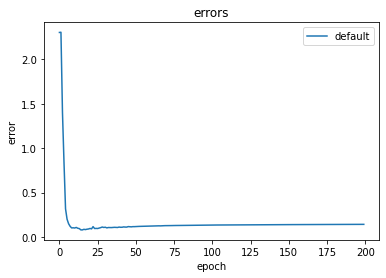

In [9]:
plot_graphs(test_log, 'loss')

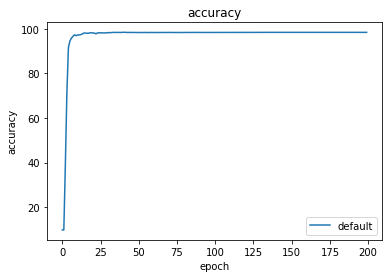

In [10]:
plot_graphs(test_log, 'accuracy')

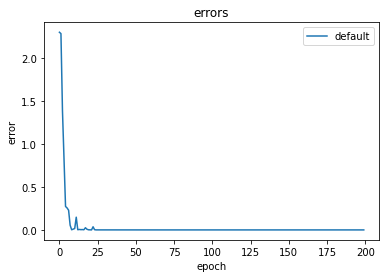

In [11]:
plot_graphs(train_log, 'loss')

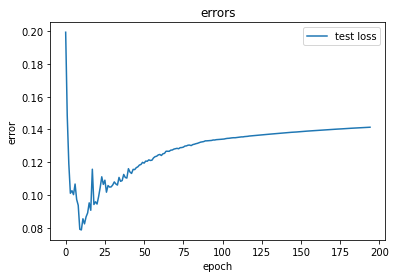

In [16]:
plot_graphs({'test loss': test_log['default'][5:]}, 'loss')

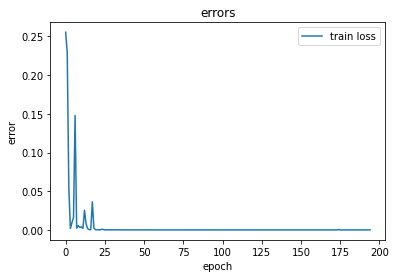

In [17]:
plot_graphs({'train loss': train_log['default'][5:]}, 'loss')

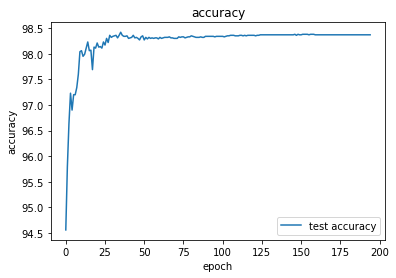

In [18]:
plot_graphs({'test accuracy': test_log['default'][5:]}, 'accuracy')